In [1]:
import torch
import torch.nn as nn
import numpy as np
import os
import sys
import cv2
from PIL import Image
import easydict
sys.path.append('../Whatiswrong')
import Extract
import utils
import torch.nn.functional as F
import easydict
import torchvision
import tensorflow as tf

In [2]:
import torchvision.models as models

In [3]:
class Basemodel(nn.Module):
    def __init__(self, opt):
        super(Basemodel, self).__init__()
        self.encoder = Resnet_EFIFSTR(with_lstm=True)
        self.decoder = 
        
    def forward(self, img)

SyntaxError: invalid syntax (<ipython-input-3-c731985bdd45>, line 5)

In [86]:
def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)

def conv1x1(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class ResnetBlock(nn.Module):

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(ResnetBlock, self).__init__()
        self.conv1 = conv1x1(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

class Resnet_encoder(nn.Module):
    def __init__(self, opt, n_group=1):
        super(Resnet_encoder, self).__init__()
        self.n_group= n_group
        self.enc_dim = opt.enc_dim
        
        in_channels=3
        self.layer0 = nn.Sequential(nn.Conv2d(in_channels, 32, kernel_size=(3,3), stride=1, padding=1, bias=False),
                                   nn.BatchNorm2d(32),
                                   nn.ReLU(inplace=True))
        self.inplanes = 32
        self.layer1 = self._make_layer(32, 3, [2,2])  
        self.layer2 = self._make_layer(64, 4, [2,2])  
        self.layer3 = self._make_layer(128, 6, [2,1]) 
        self.layer4 = self._make_layer(256, 6, [1,1])
        self.layer5 = self._make_layer(512, 3, [1,1])
        
        self.rnn = nn.LSTM(512, int(self.enc_dim/2), num_layers=2, bidirectional=True, batch_first=True)
        self.out_planes = 2 * 256

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
        
    def _make_layer(self, planes, blocks, stride):
        downsample = None
        if stride !=[1,1] or self.inplanes != planes:
            downsample = nn.Sequential(conv1x1(self.inplanes, planes, stride),
                                      nn.BatchNorm2d(planes))
            
        layers = []
        layers.append(ResnetBlock(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for _ in range(1, blocks):
            layers.append(ResnetBlock(self.inplanes, planes))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x0 = self.layer0(x)
        x1 = self.layer1(x0)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)
        x5 = self.layer5(x4)
        feature_map = x5
        feature_map_list = [x1, x2, x3, x4, x5]
        
        batch_size, channels, feature_h, feature_w = feature_map.shape
        cnn_feat = F.max_pool2d(feature_map, (feature_h, 1))
        cnn_feat = cnn_feat.permute(0, 3, 1, 2).squeeze(3)

        _, holistic_feature = self.rnn(cnn_feat)
        
        # merge bidirection to uni-direction
        hidden_state, cell_state = holistic_feature    #hidden_state (num_layers * num_direction, batch_size, enc_dim / 2 ) 
        hidden_state = hidden_state.transpose(0,1).contiguous().view(batch_size, -1, self.enc_dim ).transpose(0,1).contiguous()
        cell_state = cell_state.transpose(0,1).contiguous().view(batch_size, -1, self.enc_dim).transpose(0,1).contiguous()
        
        return feature_map_list, (hidden_state, cell_state)
                   

In [57]:
class Attention_unit(nn.Module):
    
    def __init__(self, fmap_dim, lstm_dim, attn_dim):
        super(Attention_unit, self).__init__()
        self.fmap_dim = fmap_dim
        self.lstm_dim = lstm_dim
        self.e_lstm_conv = nn.Conv2d(lstm_dim, attn_dim, kernel_size=1)
        self.e_Fmap_conv = nn.Conv2d(fmap_dim, attn_dim, kernel_size=3, padding=1)
        self.a_conv = nn.Conv2d(attn_dim, 1, kernel_size=1)
        
    def forward(self, fmap, hidden_state):
        batch_size, channel, height, width = fmap.shape
        hidden_state = hidden_state.permute(0, 2, 1).unsqueeze(3)
        e_lstm_conv_ =  self.e_lstm_conv(hidden_state)
        e_lstm_conv_ = e_lstm_conv_.repeat(1, 1, height, width)
        e_fmap_conv_ = self.e_Fmap_conv(fmap)
#         print('e_lstm_conv res : ', e_lstm_conv_.shape)
#         print('e_fmap_conv res : ', e_fmap_conv_.shape)
        e = torch.tanh_(e_lstm_conv_ + e_fmap_conv_)
        a_conv_ = self.a_conv(e)  
        a = F.softmax(a_conv_.reshape((batch_size, -1)), dim = -1)
        mask = a.reshape((batch_size, 1, height, width))
        broad_casted = (fmap * mask).reshape(batch_size, channel, -1)
        glimpse = torch.sum(broad_casted, dim= -1).reshape((batch_size, channel, 1, 1))
#         print('glimpse shape : ', glimpse.shape)
        return glimpse, mask


class Decoder(nn.Module): 
    
    def __init__(self, opt): #att dim = 512
        super(Decoder, self).__init__()
        self.num_classes = opt.num_classes
        self.fmap_dim = opt.fmap_dim
        self.enc_dim = opt.enc_dim
        self.dec_dim = opt.dec_dim
        self.attn_dim = opt.attn_dim
        self.max_length = opt.max_length
        self.attention_unit = Attention_unit(self.fmap_dim, self.dec_dim, self.attn_dim )
        self.input_embedding = nn.Embedding(self.num_classes+1, self.enc_dim) # including <BOS>
#         self.lstm = nn.LSTMCell(enc_dim, dec_dim)
        self.lstm = nn.LSTM(self.enc_dim, self.dec_dim, num_layers = 2, batch_first=True)
        
        self.fc = nn.Linear(self.dec_dim + self.fmap_dim, self.num_classes +2 ) # including <BOS>,<EOS>
        
        
    def forward(self, feature_map, holistic_feature, Input, is_train):
        x, target, length = Input
        batch_size, channel, height, width = feature_map.shape

        logits = torch.zeros(batch_size, opt.max_length+1, self.num_classes+2)  ### last class : <EOS>
        masks = torch.zeros(batch_size, opt.max_length+1, height, width )
        glimpses = torch.zeros(batch_size, opt.max_length+1, channel)
        input_label = torch.zeros(batch_size, 1, dtype= torch.long).fill_(self.num_classes) #### the second last is used as the <BOS>, 

        input_emb = self.input_embedding(input_label)
        output, states =  self.lstm(input_emb, holistic_feature)
        glimpse, mask = self.attention_unit(feature_map, output)
        glimpse = glimpse.permute(0, 2, 1, 3).squeeze(3)
        logit = self.fc(torch.cat([output, glimpse], axis=2))
        logits[:, [0], :] = logit
        masks[:,[0], :, : ] = mask
        glimpses[:, [0], : ] = glimpse
        
        if is_train:
            for i in range(self.max_length):
                input_label = target[:, [i]]
                input_emb = self.input_embedding(input_label)
                output, states = self.lstm(input_emb, states)
                glimpse, mask = self.attention_unit(feature_map, output)
                glimpse = glimpse.permute(0, 2, 1, 3).squeeze(3)
                logit = self.fc(torch.cat([output, glimpse], axis=2))
                logits[:, [i+1], :] = logit
                masks[:,[i+1], :, : ] = mask
                glimpses[:, [i+1], : ] = glimpse
        else:
            pred = torch.argmax(logit, dim=-1)
            for i in range(1, self.max_length):
                input_emb = self.input_embedding(pred)
                output, states = self.lstm(input_emb, states)
                glimpse, mask = self.attention_unit(feature_map, output)
                glimpse = glimpse.permute(0, 2, 1, 3).squeeze(3)
                logit = self.fc(torch.cat([output, glimpse], axis=2))
                loogits[:, [i], :] = logit 
                masks[:,[i+1], :, : ] = mask
                pred = torch.argmax(torch.softmax(logit, axis=-1), -1)
                glimpses[:, [i+1], : ] = glimpse
                
        return logits, masks, glimpses


In [133]:
class Generator(nn.Module):
    def __init__(self, opt):
        super(Generator, self).__init__()
        self.fc_1 = nn.Linear(int(opt.img_h/2) * int(opt.img_w/2), 16 * 16)
        self.fc_2 = nn.Linear(int(opt.img_h/4) * int(opt.img_w/4), 8 * 8)
        self.fc_3 = nn.Linear(int(opt.img_h/8) * int(opt.img_w/4), 4 * 4)
        self.font_embedding = nn.Embedding(opt.num_fonts, 128)
        self.Deconv_1 = nn.ConvTranspose2d(opt.fmap_dim + 128, 128, kernel_size =[2,2], stride=[2,2] )
        self.Deconv_2 = nn.ConvTranspose2d(128, 64, kernel_size=[2,2], stride=[2,2]) #kernel size [3,3] make output size  [T, S, 5 , 5]
        self.Deconv_3 = nn.ConvTranspose2d((64 + 128), 32, kernel_size=[2,2], stride=[2,2]) # ref : Resnet encoder layer3
        self.Deconv_4 = nn.ConvTranspose2d((32 + 64), 16, kernel_size=[2,2], stride=[2,2])  # ref : Resnet encoder layer2
        self.Deconv_5 = nn.ConvTranspose2d((16 + 32), 1, kernel_size=[2,2], stride=[2,2])   # ref : Resnet encoder layer1

    def generate_glimpse(self, fmap, masks):
        _, fmap_c, fmap_h, fmap_w = fmap.shape
        mask = F.interpolate(masks, size = (fmap_h, fmap_w), mode='bilinear', align_corners=False)
        mask = mask.repeat(1, fmap_c, 1, 1)
        fmap = fmap.unsqueeze(1)  #[N, 1, c, 24, 80]
        fmap = fmap.repeat(1, self.seq_len, 1, 1, 1).reshape((self.batch_size * self.seq_len, fmap_c, fmap_h, fmap_w))
        glimpse = torch.mul(mask, fmap)
        
        #reshape
        glimpse = glimpse.reshape((self.batch_size * self.seq_len, fmap_c, fmap_h * fmap_w))
        
        return glimpse, fmap_c
    
    
    def forward(self, feature_map_list, masks, glimpses):
        
        self.batch_size,  self.seq_len,  self.height,  self.width = masks.shape 
        masks = masks.reshape((self.batch_size * self.seq_len, 1, self.height, self.width))
        
        glimpse_s1, fmap_s1_c = self.generate_glimpse(feature_map_list[0], masks)  # feature_map_list[0] shape  # 24 * 80
        glimpse_s2, fmap_s2_c = self.generate_glimpse(feature_map_list[1], masks)   # 12 * 40
        glimpse_s3, fmap_s3_c = self.generate_glimpse(feature_map_list[2], masks)   # 6 * 40
        
        fmap_last = feature_map_list[-1] # 6 * 40
        _, feature_c, feature_h, feature_w = fmap_last.shape       
        
#         ### fmap s3
#         mask_s3 = masks.repeat(1,fmap_s1_c, 1,1)
#         fmap_s3.unsqueeze_(1) #  after unsqueeze -> [N, 1, c, 6, 40]
#         fmap_s3 = fmap_s3.repeat(1, seq_len, 1, 1, 1).reshape((batch_size * seq_len, fmap_s3_c, fmap_s3_h, fmap_s3_w))
#         glimpse_s3 = torch.mul(mask_s3, fmap_s3)
        
#         ## fmap s2
#         mask_s2 = F.interpolate(masks, size = (fmap_s2_h, fmap_s2_w), mode='bilinear', align_corners=False)
#         fmap_s2.unsqueeze_(1)  #[N, 1, c, 12, 40]
#         fmap_s2 = fmap_s2.repeat(1, seq_len, 1, 1, 1).reshape((batch_size * seq_len, fmap_s2_c, fmap_s2_h, fmap_s2_w))
#         glimpse_s2 = torch.mul(mask_s2, fmap_s2)

        glimpse_1 = self.fc_1(glimpse_s1).reshape((self.batch_size * self.seq_len , fmap_s1_c, 16, 16))
        glimpse_2 = self.fc_2(glimpse_s2).reshape((self.batch_size * self.seq_len , fmap_s2_c, 8, 8))
        glimpse_3 = self.fc_3(glimpse_s3).reshape((self.batch_size * self.seq_len , fmap_s3_c, 4, 4))
        
        embedding_ids = torch.randint(low=0, high= 104, size=(self.batch_size * self.seq_len, 1))
        font_embedded = self.font_embedding(embedding_ids).reshape((self.batch_size * self.seq_len, 128, 1, 1))
        
        # deconv stage
        glimpses_deconv = glimpses.reshape((self.batch_size * self.seq_len, feature_c, 1, 1))
        concat_deconv = torch.cat([glimpses_deconv, font_embedded], axis=1)
        
        d1 = self.Deconv_1(concat_deconv)
        d2 = self.Deconv_2(d1)
        d3 = self.Deconv_3(torch.cat([d2, glimpse_3], dim=1))
        d4 = self.Deconv_4(torch.cat([d3, glimpse_2], dim=1))
        d5 = self.Deconv_5(torch.cat([d4, glimpse_1], dim=1))
        d5 = torch.tanh(d5)
        
        glyph = d5.reshape((self.batch_size ,self.seq_len, 32 * 32)) 
        
        return glyph, embedding_ids
        

# TEST

In [46]:
opt = easydict.EasyDict({'max_length' : 10,
                        'num_classes' : 10 ,
                        'num_fonts' : 104,
                        'img_h' : 48,
                        'img_w' : 160,
                        'fmap_dim' : 512,
                        'enc_dim' : 512,
                        'attn_dim' : 512,
                        'dec_dim' : 512,
                        'batch_size' : 10 } )

In [6]:
length = opt.max_length
inputx = torch.LongTensor(list(range(length))*opt.batch_size).reshape((opt.batch_size, length))
targetx = torch.LongTensor(list(range(length))*opt.batch_size).reshape((opt.batch_size, length))
lengthx = torch.IntTensor([length]*opt.batch_size)
x = [inputx, targetx, lengthx]

- encoder

In [88]:
image = torch.FloatTensor(opt.batch_size, 3, opt.img_h, opt.img_w)

In [87]:
encoder = Resnet_encoder(opt)

In [104]:
fmap_list, holistic_state = encoder(image)

- decoder

In [106]:
decoder = Decoder(opt)
logit, masks, glimpses = decoder(fmap_list[-1], holistic_state, x, is_train=True)

- glyph_generator

In [134]:
generator = Generator(opt)
glyphs, embedding_ids = generator(fmap_list, masks, glimpses)

- recognition loss

In [146]:
criterion = torch.nn.CrossEntropyLoss()

In [157]:
target = torch.randint(0, 10, size = (10,11)) #(10, 12)

In [154]:
criterion(logit, target) #recognition loss

tensor(2.3972, grad_fn=<NllLoss2DBackward>)

- generation loss

In [173]:
ref_glyphs = torch.Tensor(np.load('data/glyphs_ko_104.npy'))

In [180]:
target_glyph_ids = target.reshape((110,1)) + 2447* embedding_ids 

tensor([[ 75861],
        [ 44046],
        [212895],
        [137035],
        [200662],
        [154162],
        [ 66077],
        [ 70971],
        [ 44048],
        [ 63630],
        [ 14687],
        [ 17138],
        [127246],
        [247150],
        [176187],
        [119910],
        [156608],
        [102775],
        [227574],
        [ 46497],
        [188423],
        [102780],
        [188425],
        [107671],
        [154161],
        [188427],
        [161510],
        [129699],
        [232470],
        [193322],
        [  7345],
        [  4894],
        [ 88096],
        [ 41602],
        [115016],
        [ 19576],
        [139485],
        [ 97887],
        [ 29367],
        [151715],
        [ 36712],
        [ 34265],
        [171299],
        [220232],
        [ 34259],
        [176192],
        [105223],
        [146822],
        [161511],
        [ 92989],
        [ 56290],
        [ 78306],
        [124798],
        [ 80751],
        [124801],
        [1

In [188]:
ref_target = ref_glyphs[target_glyph_ids.reshape(-1,)] #reshape 해야함

- font 

In [82]:
fonts = np.load('./data/glyphs_ko_104.npy')

In [192]:
from tensorflow.keras.preprocessing.image import array_to_img

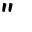

In [112]:
array_to_img(((fonts[2447*100 + 3].reshape((32, 32, 1))+1.0) * 127.5).astype(np.uint8))